In [1]:
# import all revelant packages
from headers import *
from twoPoint import *

from twoPointNoise import *
from notebook_helper_functions import *
from CMBForecast import *

In [2]:
params = {
          'output': 'tCl lCl mPk pCl mTk vCTk',
          'l_max_scalars': 10000,
          'lensing': 'yes',
          'P_k_max_h/Mpc': 10.,
          'non linear':'halofit', 
          'z_pk': '0.0,1087',
          'A_s': 2.2065e-9,
          'n_s': 0.9645,
          'h': 0.6727,
          'N_ur': 1.0196,
          'N_ncdm': 2,
          'm_ncdm': '0.01,0.05',
          'tau_reio': 0.079,
          'omega_b': 0.02225,
          'omega_cdm': 0.1198,
          'Omega_k': 0.}

cosmo = Class()   
cosmo.set(params) 
cosmo.compute() 

In [55]:
c = 299792458/1e3
H = lambda z: cosmo.Hubble(z) / 0.6727 # h / Mpc
a = lambda z: 1/(1+z)
k_hor = lambda z: a(z) * H(z)
chi = lambda z: cosmo.angular_distance(z) * (1+z) * 0.6727

(0.1, 1000000.0)

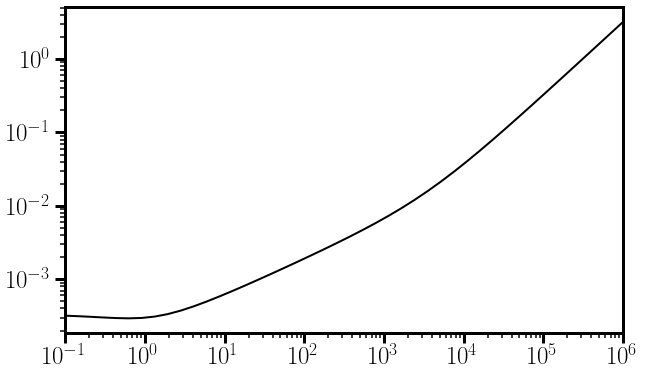

In [87]:
zs = np.logspace(-2,6,50)
ks = [k_hor(z) for z in zs]

plt.figure(figsize=(10,6))
plt.loglog(zs,ks,lw=2,c='k')
plt.xlim(1e-1,1e6)

Text(0, 0.5, '$\\ell_\\text{horizon}(z) \\equiv \\chi(z_\\star) a(z) H(z)$')

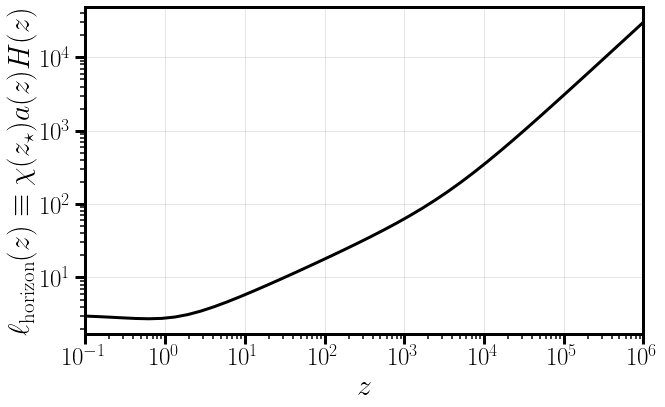

In [62]:
zs = np.logspace(-2,6,50)
ls = [k_hor(z) * chi(1098) for z in zs]

plt.figure(figsize=(10,6))
plt.loglog(zs,ls,lw=3,c='k')
plt.xlim(1e-1,1e6)
plt.grid(alpha=0.4)

plt.xlabel(r'$z$')
plt.ylabel(r'$\ell_\text{horizon}(z) \equiv \chi(z_\star) a(z) H(z)$')

In [84]:
def get_tt(log10z_c,fEDE=True):

    params = {
              'output': 'tCl lCl mPk pCl mTk vCTk',
              'l_max_scalars': 5000,
              'lensing': 'yes',
              'P_k_max_h/Mpc': 10.,
              'non linear':'halofit', 
              'z_pk': '0.0,1087',
              'A_s': 2.2065e-9,
              'n_s': 0.9645,
              'h': 0.6727,
              'N_ur': 1.0196,
              'N_ncdm': 2,
              'm_ncdm': '0.01,0.05',
              'tau_reio': 0.079,
              'omega_b': 0.02225,
              'omega_cdm': 0.1198,
              'Omega_k': 0.}

    EDE_params = {'log10z_c': log10z_c,'fEDE': 0.04,'thetai_scf': 2.83,
                           'Omega_Lambda':0.0,'Omega_fld':0,'Omega_scf':-1,
                           'n_scf':3,'CC_scf':1,'scf_tuning_index':3,
                           'scf_parameters':'1, 1, 1, 1, 1, 0.0',
                           'attractor_ic_scf':'no'}

    cosmo = Class()   
    cosmo.set(params) 
    if fEDE: cosmo.set(EDE_params) 
    cosmo.compute() 

    Tcmb = 2.725 * 1e6 # [muK]
    ucls = cosmo.raw_cl(5000)
    tt = ucls['tt'][2:] * Tcmb**2
    return tt

In [85]:
logzcs = np.array([1,2,3,4,5,6])
tts = [get_tt(logzc) for logzc in logzcs]

In [86]:
lcdm = get_tt(3,fEDE=False)

(50, 5000)

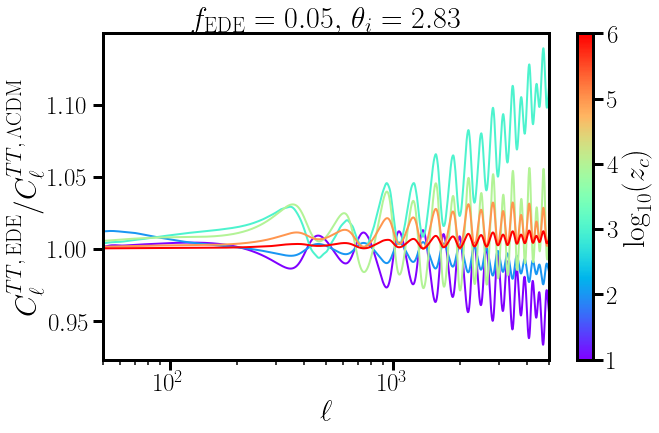

In [105]:
import matplotlib.cm as cm

l = np.arange(2,5001,1)

colors = cm.rainbow(np.linspace(0, 1, 6))

plt.figure(figsize=(10,6))
#for i,logzc in logzcs: plt.semilogx(l,tts[i] / lcdm,lw=2)
for i in range(6): plt.semilogx(l,tts[i] / lcdm,lw=2,c=colors[i])

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{TT,\,\text{EDE}}_\ell / C^{TT,\,\Lambda\text{CDM}}_\ell$')
plt.title(r'$f_\text{EDE} = 0.05,\, \theta_i = 2.83$')
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=1,vmax=6), cmap=plt.cm.rainbow), label=r'$\log_{10}(z_c)$')
plt.xlim(50,5000)

In [3]:
free_params = ['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio','fEDE']

def get_Planck_SO(log10z_c,lmax=3000):
    Planck = CMBForecast(cosmo=cosmo, name='CMB_derivs', 
                         Cxy_fid='input/Planck_fiducial_TTTEEE.txt',
                         fsky=0.8,lmax=32,log10z_c=log10z_c)

    Planck.free_params = np.array(free_params)
    Planck.compute_derivatives()
    
    lminT = 15
    lminP = 14
    lmaxT = 30
    lmaxP = 30

    F_Planck_lowell = Planck.gen_fisher(lminT,lmaxT,lminP,lmaxP)

    ####################################################################


    SO = CMBForecast(cosmo=cosmo, name='CMB_derivs', 
                     Cxy_fid='input/SO_fiducial_TTTEEE.txt',
                     fsky=0.4,lmax=3002,log10z_c=log10z_c)

    SO.free_params = np.array(free_params)
    SO.compute_derivatives()

    lminT = 30
    lminP = 30
    lmaxT = lmax
    lmaxP = lmax

    F_SO_highell = SO.gen_fisher(lminT,lmaxT,lminP,lmaxP)

    return F_Planck_lowell + F_SO_highell

In [4]:
log10z_cs = np.linspace(1.5,6.5,20)
Planck_SO = get_Planck_SO(log10z_cs[0])

In [6]:
Planck_SO = get_Planck_SO(log10z_cs[10])
sfEDE(Planck_SO) * 100

0.6719229537080174

In [15]:
_, FdesiMega =get_LLS_fishers(log10z_cs[10])
sfEDE(megaCast.combine_fishers([Planck_SO[:6,:6],FdesiMega],6)) * 100

0.8822555525920178

In [7]:
lmaxs = np.linspace(100,5000,20)

ss = []

for ll in lmaxs:
    Planck_SO = get_Planck_SO(log10z_cs[10],lmax=ll)
    ss.append(sfEDE(Planck_SO) * 100)
ss = np.array(ss)

([<matplotlib.axis.XTick at 0x7f58637c37f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

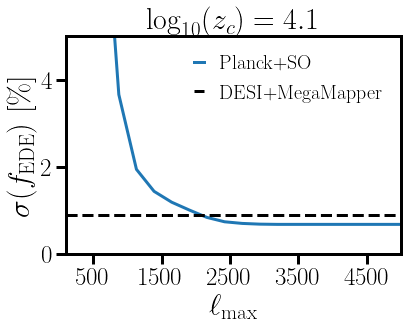

In [16]:
plt.plot(lmaxs,ss,label=r'Planck+SO',lw=3)
plt.axhline(y=0.882255,label = 'DESI+MegaMapper',c='k',ls='--',lw=3)

plt.legend(loc='upper right',frameon=False,fontsize=20,handlelength=0.5)

plt.xlabel(r'$\ell_\text{max}$')
plt.ylabel(r'$\sigma(f_\text{EDE})\,\,[\%]$')
plt.title(r'$\log_{10}(z_c) = 4.1$')
plt.xlim(lmaxs[0],lmaxs[-1])
plt.ylim(0,5)
plt.xticks([500,1500,2500,3500,4500])

In [8]:
# compare with Simo's forecasts
Planck_SO_Simo = np.genfromtxt('input/Planck_SO.txt')[:6,:6]

Noah_constraints = np.sqrt(np.diag(np.linalg.inv(Planck_SO[:6,:6])))
Simo_constraints = np.sqrt(np.diag(np.linalg.inv(Planck_SO_Simo)))

print('Ratio of my to Simos constraints')
for i in range(6):
    ratio = round(Noah_constraints[i]/Simo_constraints[i],3)
    print(free_params[i],':',ratio)

Ratio of my to Simos constraints
h : 1.086
log(A_s) : 0.92
n_s : 1.158
omega_cdm : 1.081
omega_b : 1.071
tau_reio : 0.963


In [9]:
basis = np.array(['h','log(A_s)','n_s','omega_cdm','omega_b','tau_reio',\
                  'fEDE','N','alpha0','b','b2','bs','N2','N4','alpha2','alpha4'])

# set up the DESI forecast
DESI = experiment(zmin=0.6, zmax=1.7, nbins=4, fsky=0.34, sigma_z=0.0, ELG=True)
desiCast = fisherForecast(experiment=DESI,cosmo=cosmo,\
                          Nk=2000,Nmu=100,velocileptors=True,name='DESI')

desiCast.log10z_c = log10z_cs[0]
derivatives_desi = desiCast.load_derivatives(basis)

# set up the MegaMapper forecast 
n = interp1d([2,3,4,5],np.array([9.8,1.2,1.0,0.4])*(1e-4),kind='linear')
MegaMapper = experiment(zmin=2., zmax=5., nbins=4, fsky=0.34, sigma_z=0.0, n=n, LBG=True, custom_n=True)
megaCast = fisherForecast(experiment=MegaMapper,cosmo=cosmo,\
                          Nk=2000,Nmu=100,velocileptors=True,name='MegaMapper_fiducial')

megaCast.log10z_c = log10z_cs[0]
derivatives_mega = megaCast.load_derivatives(basis)

In [10]:
def get_LLS_fishers(log10z_c):
    desiCast.log10z_c = log10z_c
    d = desiCast.load_derivatives(np.array(['fEDE']))
    derivatives_desi[:,6,:] = d[:,0,:]
    Fdesi = desiCast.gen_fisher(basis,7,derivatives=derivatives_desi)
    #
    megaCast.log10z_c = log10z_c
    d = megaCast.load_derivatives(np.array(['fEDE']))
    derivatives_mega[:,6,:] = d[:,0,:]
    Fmega = megaCast.gen_fisher(basis,7,derivatives=derivatives_mega)
    #
    FdesiMega = megaCast.combine_fishers([Fdesi,Fmega],7)
    return Fdesi,FdesiMega

In [5]:
def sfEDE(F): return np.sqrt(np.linalg.inv(F)[6,6])

def get_fEDE_constraints(log10z_c):
    Fdesi,FdesiMega = get_LLS_fishers(log10z_c)
    Planck_SO = get_Planck_SO(log10z_c)
    res = []
    # LCDM prior (Simo)
    F = megaCast.combine_fishers([Planck_SO_Simo,Fdesi],6)
    res.append(sfEDE(F))
    # LCDM prior (Noah)
    F = megaCast.combine_fishers([Planck_SO[:6,:6],Fdesi],6)
    res.append(sfEDE(F))
    # LCDM+fEDE prior (Noah)
    F = megaCast.combine_fishers([Planck_SO,Fdesi],7)
    res.append(sfEDE(F))
    # add MegaMapper
    F = megaCast.combine_fishers([Planck_SO_Simo,FdesiMega],6)
    res.append(sfEDE(F))
    F = megaCast.combine_fishers([Planck_SO[:6,:6],FdesiMega],6)
    res.append(sfEDE(F))
    F = megaCast.combine_fishers([Planck_SO,FdesiMega],7)
    res.append(sfEDE(F))
    # CMB alone
    res.append(sfEDE(Planck_SO))
    # CMB fEDE is varied independently of LLS fEDE
    F = megaCast.combine_fishers([FdesiMega,Planck_SO],6)
    res.append(sfEDE(F))
    return res

In [9]:
constraints = []
for log10z_c in log10z_cs: constraints.append(get_fEDE_constraints(log10z_c))
constraints = np.array(constraints)

(0.25, 55)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


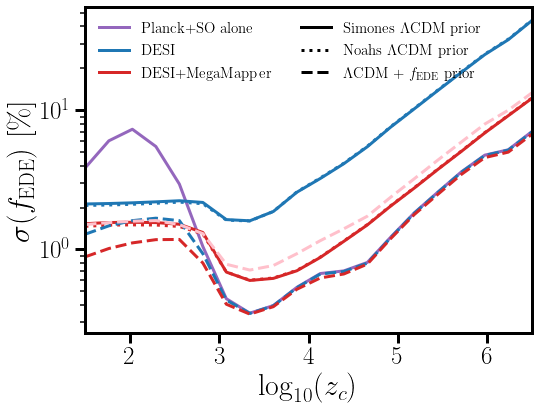

In [10]:
plt.figure(figsize=(8,6))

plt.semilogy(log10z_cs,constraints[:,6]*100,c='C4',lw=3,ls='-',label=r'Planck+SO alone')

plt.semilogy(log10z_cs,constraints[:,0]*100,c='C0',lw=3,label=r'DESI')
plt.semilogy(log10z_cs,constraints[:,3]*100,c='C3',lw=3,label=r'DESI+MegaMapper')

plt.semilogy(log10z_cs,constraints[:,1]*100,c='C0',lw=3,ls='dotted')
plt.semilogy(log10z_cs,constraints[:,4]*100,c='C3',lw=3,ls='dotted')

plt.semilogy(log10z_cs,constraints[:,2]*100,c='C0',lw=3,ls='--')
plt.semilogy(log10z_cs,constraints[:,5]*100,c='C3',lw=3,ls='--')

plt.semilogy(log10z_cs,constraints[:,7]*100,c='pink',lw=3,ls='--')


plt.semilogy([],[],lw=3,c='k',ls='-',label=r'Simones $\Lambda$CDM prior')
plt.semilogy([],[],lw=3,c='k',ls='dotted',label=r'Noahs $\Lambda$CDM prior')
plt.semilogy([],[],lw=3,c='k',ls='--',label=r'$\Lambda$CDM $+$ $f_\text{EDE}$ prior')

plt.legend(loc='upper left',frameon=False,fontsize=15,ncol=2)
plt.xlabel(r'$\log_{10}(z_c)$')
plt.ylabel(r'$\sigma(f_\text{EDE})\,\,[\%]$')
plt.xlim(1.5,6.5)
plt.ylim(0.25,55)

In [12]:
constraints[:,3]/constraints[:,7] - 1

array([ 0.01448461,  0.00112123, -0.01762589, -0.03255038,  0.00712231,
        0.01859188, -0.12148276, -0.15799925, -0.19142926, -0.24610724,
       -0.24236854, -0.18745992, -0.13442485, -0.13583264, -0.14270505,
       -0.14343865, -0.14354988, -0.13668581, -0.08654934, -0.08674907])